In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

### Init Params

In [77]:
data_path = r'./data'
look_back = 14
look_ahead = 7
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2

### Conv 1D Model for time series prediction

In [78]:
model = keras.Sequential()
model.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(look_back, 1)))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(look_ahead))
model.compile(loss='mean_absolute_error', optimizer=optimizers.Adam(), metrics=['mean_absolute_error'])

### Utils functions

In [79]:
def mean_relative_error(forecast, actual):
    return 100 * np.mean(np.abs(forecast - actual) / actual)


def create_dataset_future(X, look_back=1, look_ahead=7):
    Xs, ys = [], []
    for i in range(len(X) - look_back - look_ahead + 1):
        Xs.append(X[i: i + look_back])
        ys.append(X[i + look_back: i+look_back+look_ahead])
    return np.array(Xs), np.array(ys)

### Training

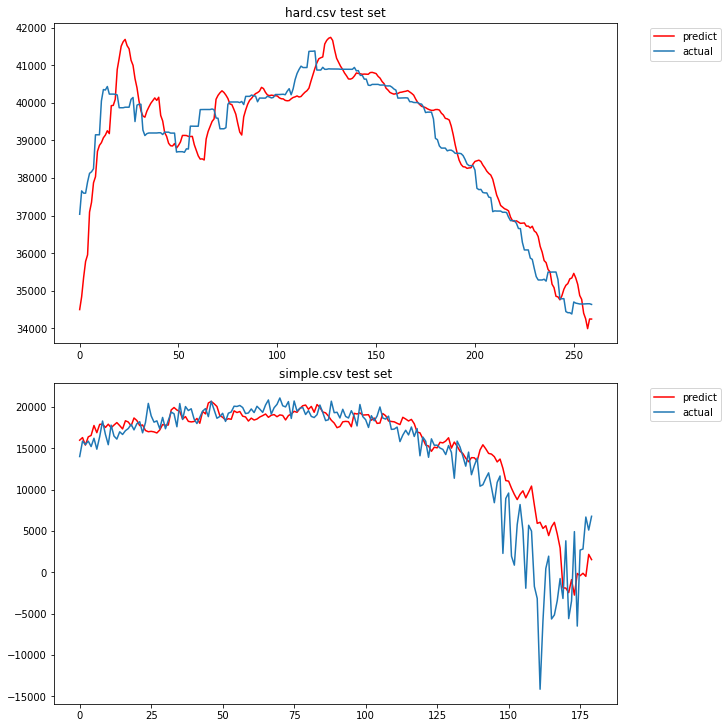

In [80]:
assert train_ratio + valid_ratio + test_ratio == 1

fig, ax = plt.subplots(2, figsize=(10,10), constrained_layout=True)
#fig.tight_layout() 


for i_fig, f_name in enumerate(os.listdir(data_path)):
    ts_name = f_name.split('.')[0]
    
    #creating dirs for caching best models
    model_path = os.path.join(r'./models', f'model_{ts_name}')
    if not os.path.exists(model_path):
        os.makedirs(model_path) 
    
    
    ts = pd.read_csv(os.path.join(data_path, f_name), header=None)[0]
    iloc_train_valid = int(len(ts) * train_ratio)
    iloc_valid_test = iloc_train_valid + int(len(ts) * valid_ratio)
    ts_train = ts[:iloc_train_valid].values
    ts_valid = ts[iloc_train_valid:iloc_valid_test].values
    ts_test  = ts[iloc_valid_test:].values
    
    
    X_train, y_train = create_dataset_future(ts_train, look_back, look_ahead)
    X_valid, y_valid = create_dataset_future(ts_valid, look_back, look_ahead)
    X_train = np.expand_dims(X_train, -1)
    X_valid = np.expand_dims(X_valid, -1)
    
    #saving best models while training
    model_names = os.path.join(model_path, '{val_mean_absolute_error:.1f}.hdf5')
    model_checkpoint = ModelCheckpoint(model_names, 
                                       monitor='val_mean_absolute_error', 
                                       verbose=0,
                                       save_best_only=True)
    model.fit(X_train,
              y_train,
              epochs=10000,
              batch_size=500,
              verbose=0,
              validation_data=(X_valid, y_valid),
              callbacks=[model_checkpoint])
    
    #detecting best model in model foler
    models_current = [model_name for model_name in os.listdir(model_path)]
    models_errs = np.array([float(os.path.splitext(model_name)[0]) for model_name in models_current])
    lowest_err_idx = np.argmin(models_errs)
    
    #removing all but best model
    for idx, model_name in enumerate(models_current):
        if idx == lowest_err_idx:
            continue
        os.remove(os.path.join(model_path, model_name))
    
    
    #using best model weights for conv1D architecture
    best_model = models_current[lowest_err_idx]
    model.load_weights(os.path.join(model_path, best_model))
    X_test, y_test = create_dataset_future(ts_test, look_back, look_ahead)
    X_test = np.expand_dims(X_test, -1)
    
    #look_ahead 
    y_pred = model.predict(X_test)[:, -1]
    ax[i_fig].plot(y_pred, color='r', label="predict")
    ax[i_fig].plot(y_test[:,-1], label="actual")
    ax[i_fig].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax[i_fig].set_title(f'{f_name} test set')
    
    